In [1]:
import copy
import sys
from typing import *

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tabulate

import wandb

sns.set_context("paper", font_scale=1.5)
matplotlib.rc("font", family="serif", serif=["CMU Serif"])
matplotlib.rc("text", usetex=True)
# matplotlib.rc("font", family="sans-serif"); matplotlib.rc("text", usetex=False)
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

api = wandb.Api()

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


# Analysis

In [2]:
def get_results(run: wandb.apis.public.Run) -> Iterable[Dict[str, Any]]:
    if "results" in run.summary:
        c = run.config["sparsity"]
        if c["name"] == "dense":
            compression = 1
        elif c["name"] == "ann":
            compression = 1 / (c["k"] + c["rank"] / 128)
        else:
            compression = 1 / c["k"]
        for result in run.summary["results"]:
            yield dict(**c, compression=compression, **result)

df = pd.DataFrame(r for run in api.runs("research/sparse-attention", {"config.name": "RMOE-91-needle-v6"}) for r in get_results(run))
# df = pd.DataFrame(r for run in api.runs("research/sparse-attention", {"config.name": "RMOE-91-needle-v7-numeric-needle"}) for r in get_results(run))
df.groupby(["name", "k", "rank"], dropna=False)[["compression", "match"]].mean().sort_values("match", ascending=False)

compression     match
name     k     rank                       
dense    NaN   NaN           1.0  0.978516
ann      0.250 32.0          2.0  0.955078
         0.125 16.0          4.0  0.912109
local    0.500 NaN           2.0  0.484375
         0.250 NaN           4.0  0.232422
eviction 0.500 NaN           2.0  0.230469
         0.250 NaN           4.0  0.076172

In [17]:
df.pipe(lambda d: d[d.compression.isin([1, 4])]).groupby(["name", "k", "rank"], dropna=False).match.mean().to_frame().sort_values("match", ascending=False).style.format("{:.1%}")

,,,match
name,k,rank,
dense,nan,nan,97.9%
ann,0.125000,16.000000,91.2%
local,0.250000,nan,23.2%
eviction,0.250000,nan,7.6%


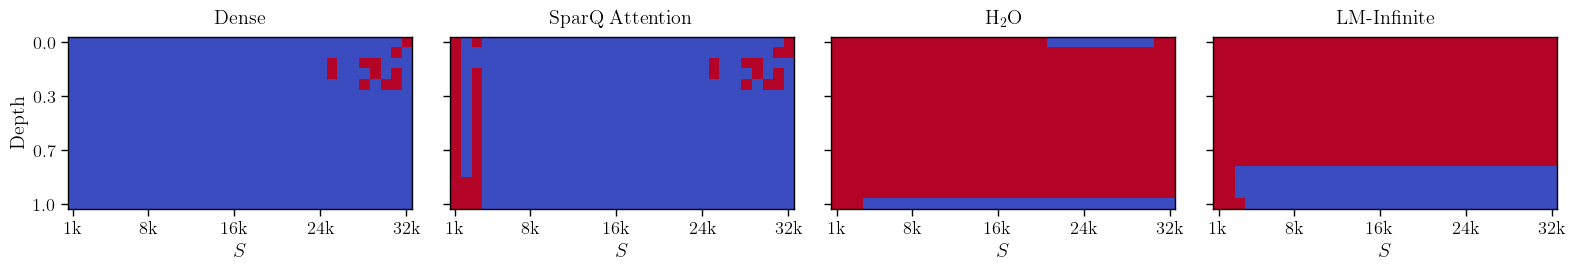

In [21]:
methods = dict(dense="Dense", ann="SparQ Attention", eviction="H$_2$O", local="LM-Infinite")

d = df.pipe(lambda d: d[(d.name == "dense") | (d["compression"] == 4)])

_, axs = plt.subplots(1, len(methods), sharey=True, figsize=(4 * len(methods), 3))
for name, ax in zip(["dense", "ann", "eviction", "local"], axs):
    table = d[d["name"] == name].pivot_table(index="depth", columns="length", values="match")
    ax.imshow(table, cmap="coolwarm_r", vmin=0, vmax=1, aspect=1)
    ax.set_title(methods[name], pad=10)
    yticks = list(enumerate(table.index))[::5]
    ax.set_yticks([n for n, _ in yticks], [f"{x:.1f}" for _, x in yticks])
    xticks = [(i, table.columns[i]) for i in [0, 7, 15, 23, 31]]
    ax.set_xticks([n for n, _ in xticks], [f"{(x + 128)/1024:.0f}k" for _, x in xticks])
    ax.tick_params(axis="x", labelrotation=0)
    ax.set_ylabel("" if ax is not axs[0] else "Depth")
    ax.set_xlabel("$S$")
plt.tight_layout()

# Errors

In [44]:
print("Errors (SparQ, 4x):\n")
print("Length  Depth  Output")
dense_errors = set(df.pipe(lambda d: d[(d.name=="dense") & (~d.match)]).id)
for _, row in (df.pipe(lambda d: d[(d.name=="ann") & (d.compression==4)]).pipe(lambda d: d[~d.match & ~d.id.isin(dense_errors)])).iterrows():
    print(f" {row.length + 128:>5}   {row.depth:.2f}  {row.output!r}")

Errors (SparQ, 4x):

Length  Depth  Output
  1024   0.00  'eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat'
  1024   0.07  'eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat'
  1024   0.13  'eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat'
  1024   0.20  'eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat'
  1024   0.27  'eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat'
  1024   0.33  'eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat'
  1024   0.40  'eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat'
  1024   0.47  'eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat'
  1024   0.53  'eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat eat'
  1024   0.60  'eat eat a sandwich and sit in Dolores Park on a sunny day."\n\n\n'
 